In [73]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, circuit, extensions
import matplotlib.pyplot as plt
import math
import numpy as np
from functools import reduce
import pandas as pd
from sklearn.model_selection import train_test_split
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
from datetime import datetime
from qiskit.aqua.components.optimizers import COBYLA, ADAM, AQGD, NFT
from datetime import datetime
import time

# Constants

In [74]:
#CONSTANTSSSSSS

#data
n_data_points = 8
data_dimensionality = 2


#generator constants
circuit_depth = 2
circuit_width = math.ceil(math.log2(data_dimensionality)) + 1 + math.ceil(math.log2(n_data_points))


# Data prep

In [75]:
df = pd.read_csv("bezdekIris.data", header=None)
#give classes numbers
df[4] = [0 if p == "Iris-setosa" else 1 if p == "Iris-virginica" else 2 for p in df[4]]
#reduce to just 2 classes
df = df[df[4] != 2]

In [76]:
train, test = train_test_split(df, test_size=0.36)
data = train[[0,1]].to_numpy()
labels = train[4].to_numpy()

n_label0s = n_data_points / 2
n_label1s = n_data_points / 2

label0s = []
label1s = []

for i in range(len(labels)):
    if labels[i] == 0 and n_label0s > 0:
        n_label0s -= 1
        label0s.append(i)
        
    if labels[i] == 1 and n_label1s > 0:
        n_label1s -= 1
        label1s.append(i)
        
    if n_label0s < 1 and n_label1s < 1:
        break

idx = label0s + label1s
        
data = data[idx]
labels = labels[idx]

# Helper functions

In [77]:
def normalize(l):
    normalization_factor = math.sqrt(sum([i ** 2 for i in l]))
    return [i / normalization_factor for i in l]

def init_gate(init_states, label=None, size=None, as_gate=True):
    if not size:
        size = math.ceil(math.log2(len(init_states)))
    state_vector = normalize(init_states) + [0] * ((2 ** size) - len(init_states))
    if as_gate:
        #I know this is way ugly, but it's the easiest way to actualy turn initialize() into a gate
        return extensions.Initialize(state_vector).gates_to_uncompute().inverse().to_gate(label=label if label else None)
    else:
        return extensions.Initialize(state_vector).gates_to_uncompute().inverse()

In [78]:
def x_indices(i, bits):
    indices = []
    for j in range(bits):
        bit = (i >> j) & 1
        if not bit:
            indices.append(j)
    return indices

In [79]:
def destructive_swap(n):
    q = QuantumRegister(n * 2)
    circuit = QuantumCircuit(q)
    
    for i in range(n):
        circuit.cx(i, n+i)
        circuit.h(i)
    return circuit.to_gate(label="destructive_swap")

def interpret_des_swap(counts):
    successes = 0
    for k in counts:
        #success if and of measurement has even parity, that's what the paper said
        success = reduce(lambda b, p: (p == ('1', '1')) ^ b , zip(list(k[:len(k)//2]), list(k[len(k)//2:])), True)
        if success:
            successes += counts[k]
    if sum(counts.values()) == 0:
        return 0
    return  2 * (successes / sum(counts.values())) - 1

In [80]:
def swap(n):
    q = QuantumRegister(n * 2 + 1)
    circuit = QuantumCircuit(q)
    circuit.h(q[0])
    
    for i in range(0, n):
        circuit.cswap(0, 1 + i, 1 + n+i)
    circuit.h(q[0])
#     print(circuit)
    return circuit.to_gate(label="swap")
# swap(2)

In [81]:
def seriessum(n):
    n_sum = 0
    for i in range(n):
        n_sum += i
    return n_sum

# Oracle meuk

In [82]:
def construct_oracle(data, labels):
    # gate = init_gate([0,2,10], "psi_0")
    data_bits = math.ceil(math.log2(data.shape[1]))
    counting_bits = math.ceil(math.log2(data.shape[0]))
    q = QuantumRegister(data_bits + counting_bits + 1)
    qc = QuantumCircuit(q)

#     data = [[x,x*2,x**2] for x in range(1, 16)]
    qc.h(q[data_bits + 1:])
    for i in range(len(data)):
        x_i = [data_bits + 1 + x_i for x_i in x_indices(i,counting_bits)]
        if len(x_i) > 0:
            qc.x(x_i)
        gate = init_gate(data[i], f"psi_{i}", data_bits, as_gate=True).control(counting_bits)
#         gate.draw()
        
#         gate_decomposed = gate.decompose()
        
#         print(gate_decomposed)
        
        qc.append(gate, q[data_bits + 1:] + q[:data_bits])
        if labels[i] == 1:
            x_gate = circuit.library.XGate().control(counting_bits)
            qc.append(x_gate, q[data_bits + 1:] + [q[data_bits]])

        if len(x_i) > 0:
            qc.x(x_i)
    return qc, data_bits, counting_bits

In [83]:
oracle, _, _ = construct_oracle(data, labels)
dec_oracle = oracle.decompose()
dec_oracle.draw()

print(dec_oracle.depth())
print(dec_oracle.num_qubits)

# times = []
# for i in range(100):
#     start = time.time()

#     backend = Aer.get_backend('qasm_simulator')
#     job = execute(backend=backend, experiments=dec_oracle, shots=10000)
#     result = job.result()
#     # print(result.counts())

#     end = time.time()

#     times.append(end - start)
#     print(end - start)

# print("avg", np.mean(times))

282
5


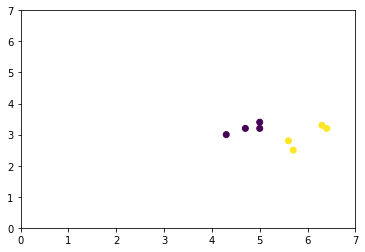

In [84]:
plt.scatter(x=data[:, 0], y=data[:, 1], c=labels)
plt.xlim([0,7])
plt.ylim([0,7])

plt.show()

# Classifier

In [85]:
def construct_destructive_classifier(oracle, data_bits, oracle_label="oracle"):
    oracle_gate = oracle.to_gate(label=oracle_label)

    q = QuantumRegister(data_bits + oracle.num_qubits)
    c = ClassicalRegister(data_bits * 2 + 1)
    qc = QuantumCircuit(q, c)
    
    qc.append(oracle, q[data_bits:])
    qc.append(destructive_swap(data_bits), q[:data_bits] + q[data_bits:data_bits+data_bits])
    for i in range(data_bits * 2 + 1):
        qc.measure(i,i)
    return qc

In [14]:
def classify_destructive(inp, classifier):
    num_qubits = classifier.num_qubits

    data_size = math.ceil(math.log2(len(inp)))

    num_cbits = data_size * 2 + 1


    q = QuantumRegister(num_qubits)
    c = ClassicalRegister(num_cbits)
    qc = QuantumCircuit(q, c)

    # inp_gate = init_gate([1,2,0,4])
    inp_gate = init_gate(inp, label="input", size=data_size)


    qc.append(inp_gate, q[:data_size])
    qc = qc.compose(classifier)
    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=qc, shots=10001)
    result = job.result()

    counts = result.get_counts()
    counts_0 = {key[1:]:value for key, value in counts.items() if key[0] == '0'}
    counts_1 = {key[1:]:value for key, value in counts.items() if key[0] == '1'}

    return (interpret_des_swap(counts_0), interpret_des_swap(counts_1))

In [15]:
def eval_classifier(data, labels, test, oracle, log=False):
    data_bits = math.ceil(math.log2(data.shape[1]))
    classifier = construct_destructive_classifier(oracle, data_bits)

    label_names = [0,1]
    correct = 0
    count = 0
    
    classification_results = []
    
    for index, row in test.iterrows():
        label = row[4]
        results = classify_destructive(row[[0,1]].tolist(), classifier)
        cor = False
        if results[0] > results[1]:
            class_estimate = 0
        else:
            class_estimate = 1
        
        if results[0] > results[1] and label == label_names[0]:
            correct += 1
            cor = True
        elif results[0] < results[1] and label == label_names[1]:
            correct += 1
            cor = True
        count += 1
        classification_results.append((class_estimate, results))
        if log:
            print(f"features:({row[0]}, {row[1]}), label:{label}, result:{label_names[0]}:{results[0]}, {label_names[1]}:{results[1]}, {'correct' if cor else 'incorrect'}, accuracy:{correct / count}")

    return correct / len(test), classification_results
    

# Generator

In [16]:
# n_features gets boiled down to amount of qubits necessary for it to work TODO: Change n_labels to do the same
def build_variational_circuit(depth, generator_width, params=None, measurement=False):
    # TODO: Add y and z rotations
    n_qubits = generator_width
    
    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum
    
    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_rot_qubits_per_layer + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)
    
#     print(params)
    
    if params is None:
        params = np.random.rand(depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi
    
#     print(params)
    
#     print(len(params))
    
    q = QuantumRegister(n_qubits)
    if measurement:
        c = ClassicalRegister(n_qubits)
        qc = QuantumCircuit(q, c)
    else:
        qc = QuantumCircuit(q)
        
    
    # Dynamically add rx rotation and rxx entanglement gates
    for i in range(depth):
        for j in range(n_qubits):
#             print(i * depth, j)
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            qc.rx(params[i * n_qubits_per_layer + j*2], j)
            qc.rz(params[i * n_qubits_per_layer + j*2 + 1], j)
        next_param = 0
        for j in range(n_qubits):
#             print(i * n_qubits_per_layer, j, (i * n_qubits_per_layer) + j)
            for k in range(n_qubits):
                if j == k or j < k:
                    continue
#                 print(i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param)
#                 print(i * n_rot_qubits_per_layer + j + next_param + n_rot_qubits_per_layer)
                qc.rxx(params[i * n_qubits_per_layer + n_rot_qubits_per_layer + next_param], j, k)
                next_param += 1
        
        if measurement:
            qc.barrier()
    
#     print(qc.depth())
    
    if measurement:
        for i in range(n_qubits):
            qc.measure(i, i)
            
            
    return qc
      
# build_variational_circuit(8, 2, 1, measurement=True).draw()

In [17]:
def generate_params(circuit_depth, circuit_width):

    n_qubits = circuit_width

    def seriessum(n):
        n_sum = 0
        for i in range(n):
            n_sum += i
        return n_sum

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    generated_params = np.random.rand(circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)) * math.pi

    return generated_params

In [18]:
accs = []
for i in range(20):
    train, test = train_test_split(df, test_size=0.36)
    data = train[[0,1]].to_numpy()
    labels = train[4].to_numpy()

    n_label0s = n_data_points / 2
    n_label1s = n_data_points / 2

    label0s = []
    label1s = []

    for i in range(len(labels)):
        if labels[i] == 0 and n_label0s > 0:
            n_label0s -= 1
            label0s.append(i)

        if labels[i] == 1 and n_label1s > 0:
            n_label1s -= 1
            label1s.append(i)

        if n_label0s < 1 and n_label1s < 1:
            break

    idx = label0s + label1s

    data = data[idx]
    labels = labels[idx]
    classifier, _, _ = construct_oracle(data, labels)
#     classifier = build_variational_circuit(circuit_depth, circuit_width)
    acc, _ = eval_classifier(data, labels, test, classifier, log=False)
    print(acc)
    accs.append(acc)
    
print(accs)
print("mean acc", np.mean(accs))

1.0


KeyboardInterrupt: 

In [19]:
acc, _ = eval_classifier(data, labels, test, classifier, log=True)

features:(4.6, 3.4), label:0.0, result:0:0.998003992015968, 1:0.9491083951112003, correct, accuracy:1.0
features:(4.8, 3.0), label:0.0, result:0:0.9979368681658758, 1:0.9840900271633684, correct, accuracy:1.0
features:(6.5, 3.0), label:1.0, result:0:0.9764518060267411, 1:0.9995991983967936, correct, accuracy:1.0
features:(4.3, 3.0), label:0.0, result:0:1.0, 1:0.9590712317985046, correct, accuracy:1.0
features:(4.8, 3.0), label:0.0, result:0:0.9987679671457905, 1:0.975443383356071, correct, accuracy:1.0
features:(6.1, 2.6), label:1.0, result:0:0.9577549788774895, 1:1.0, correct, accuracy:1.0
features:(5.7, 2.5), label:1.0, result:0:0.9640113222806308, 1:1.0, correct, accuracy:1.0
features:(6.0, 2.2), label:1.0, result:0:0.9368932038834952, 1:0.9944631204271308, correct, accuracy:1.0
features:(6.7, 3.0), label:1.0, result:0:0.9644268774703557, 1:1.0, correct, accuracy:1.0
features:(5.1, 3.4), label:0.0, result:0:1.0, 1:0.9719145569620253, correct, accuracy:1.0
features:(5.8, 2.7), label:

# Gan

In [20]:
def build_gan_stack(depth, width, orcale, params=None):
    n_data_qubits = width - 1
    
    generator = build_variational_circuit(depth, width, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = oracle.num_qubits + generator.num_qubits + 1
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
    generator_output_qubits = q[1:1 + n_data_qubits + 1]
    oracle_qubits = q[generator.num_qubits + 1:]
    oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + 1 + n_data_qubits]
    oracle_label_qubits = q[generator.num_qubits + 1 + n_data_qubits:generator.num_qubits + 1 + n_data_qubits + 1]

    oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    
    swap_test_gate = swap(n_data_qubits + 1)
    swap_test_qubits = swap_ancilla + generator_output_qubits + oracle_output_qubits + oracle_label_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

oracle, data_bits, counting_bits = construct_oracle(data, labels)
build_gan_stack(circuit_depth, data_bits + 1, oracle).draw()

┌───────┐┌─┐
q2646_0: ──────────────┤0      ├┤M├
         ┌────────────┐│       │└╥┘
q2646_1: ┤0           ├┤1      ├─╫─
         │  generator ││       │ ║ 
q2646_2: ┤1           ├┤2 swap ├─╫─
         └┬─────────┬─┘│       │ ║ 
q2646_3: ─┤0        ├──┤3      ├─╫─
          │         │  │       │ ║ 
q2646_4: ─┤1 oracle ├──┤4      ├─╫─
          │         │  └───────┘ ║ 
q2646_5: ─┤2        ├────────────╫─
          └─────────┘            ║ 
  c83: 1/════════════════════════╩═
                                 0

In [21]:
def build_gan_stack_with_count(depth, width, oracle, params=None):
#     oracle, n_data_qubits, n_counting_qubits = construct_oracle(data, labels)
#     width = oracle.num_qubits
    generator = build_variational_circuit(depth, width, params=params)
    
    oracle_gate = oracle.to_gate(label="oracle")
    generator_gate = generator.to_gate(label="generator")
    
    n_qubits = oracle.num_qubits + generator.num_qubits + 1
    
    q = QuantumRegister(n_qubits)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q, c)
    
    swap_ancilla = q[:1]
    generator_qubits = q[1:generator.num_qubits + 1]
#     generator_output_qubits = q[1:1 + width]
    oracle_qubits = q[generator.num_qubits + 1:]
#     oracle_output_qubits = q[generator.num_qubits + 1: generator.num_qubits + width]
#     oracle_label_qubits = q[generator.num_qubits + 1 + width - 1:generator.num_qubits + width + 1]

#     oracle_counting_qubits = q[generator.num_qubits + 1 + n_data_qubits + 1:]
    
    qc.append(generator_gate, generator_qubits)
    qc.append(oracle_gate, oracle_qubits)
    swap_test_gate = swap(oracle.num_qubits)
    swap_test_qubits = swap_ancilla + generator_qubits + oracle_qubits
#     print(len(generator_output_qubits), len(oracle_output_qubits), len(oracle_label_qubits))
    
    qc.append(swap_test_gate, swap_test_qubits)
    
    qc.measure(0, 0)
    
    return qc

build_gan_stack_with_count(circuit_depth, circuit_width, construct_oracle(data, labels)[0]).draw()

┌───────┐┌─┐
q2654_0: ──────────────┤0      ├┤M├
         ┌────────────┐│       │└╥┘
q2654_1: ┤0           ├┤1      ├─╫─
         │            ││       │ ║ 
q2654_2: ┤1 generator ├┤2      ├─╫─
         │            ││       │ ║ 
q2654_3: ┤2           ├┤3 swap ├─╫─
         └┬─────────┬─┘│       │ ║ 
q2654_4: ─┤0        ├──┤4      ├─╫─
          │         │  │       │ ║ 
q2654_5: ─┤1 oracle ├──┤5      ├─╫─
          │         │  │       │ ║ 
q2654_6: ─┤2        ├──┤6      ├─╫─
          └─────────┘  └───────┘ ║ 
  c84: 1/════════════════════════╩═
                                 0

In [22]:
def train_gan(gan_builder, data, labels, iterations):
    intermediate_results = []

    n_qubits = circuit_width

    n_rot_qubits_per_layer = n_qubits * 2
    n_qubits_per_layer = n_qubits * 2 + seriessum(n_qubits)
    n_entangle_qubits_per_layer = seriessum(n_qubits)

    param_size = circuit_depth * (n_rot_qubits_per_layer + n_entangle_qubits_per_layer)
    total_runs = 0
    
    oracle,_,_ = construct_oracle(data, labels)
    init_params = generate_params(circuit_depth, circuit_width)

    
    best_result = -np.Inf
    best_params = init_params
    
    def objective_function(params):
        nonlocal total_runs
        nonlocal best_result
        nonlocal best_params
        params.shape = (params.size // param_size, param_size)
        results = []
        tracked_inter_res = False

        total_runs += params.shape[0]
        for param_set in params:
            # construct circuit with given params
            qc = gan_builder(circuit_depth, circuit_width, oracle, param_set)

            backend = Aer.get_backend('qasm_simulator')
            job = execute(backend=backend, experiments=qc, shots=100000)
            counts = job.result().get_counts()

            result = 2 * counts['0'] / sum(counts.values()) - 1
            if not tracked_inter_res:
                print("counts: ", counts)
                print("Intermediate:", result)
                print("total runs: ", total_runs)
                intermediate_results.append(-result)
                tracked_inter_res = True
                
            if result > best_result:
                best_result = result
                best_params = param_set
            
            results.append(-result)

        return results


    print("Initial parameters:", init_params)
    # objective_function(params)

    # optimizer = COBYLA(maxiter=100)
    optimizer = AQGD(maxiter=iterations)

    ret = optimizer.optimize(num_vars=len(init_params), objective_function=objective_function, initial_point=init_params)

    print("Supposed optimal parameters:", ret)
    plt.plot(intermediate_results)
    plt.title("Swap test per iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Swap test")
    plt.ylim(-1, 0)
    plt.show()
    return best_result, best_params


# evaluation

In [86]:
#accuracy with real data classifier
accuracy_oracle, results_oracle = eval_classifier(data, labels, test, construct_oracle(data, labels)[0], log=True)

features:(6.8, 3.0), label:1.0, result:0:0.9632628876160378, 1:0.9983799108950993, correct, accuracy:1.0
features:(5.0, 3.5), label:0.0, result:0:0.9995983129142398, 1:0.9733174034249303, correct, accuracy:1.0
features:(7.6, 3.0), label:1.0, result:0:0.9491833030852994, 1:0.9940499801666005, correct, accuracy:1.0
features:(5.1, 3.8), label:0.0, result:0:0.9988009592326139, 1:0.9675805483289974, correct, accuracy:1.0
features:(4.4, 3.0), label:0.0, result:0:1.0, 1:0.9772953594901415, correct, accuracy:1.0
features:(4.6, 3.6), label:0.0, result:0:0.9964878048780488, 1:0.9520098441345366, correct, accuracy:1.0
features:(7.7, 2.6), label:1.0, result:0:0.930720506730008, 1:0.9826227520711255, correct, accuracy:1.0
features:(5.1, 3.5), label:0.0, result:0:0.999599358974359, 1:0.9792373727290877, correct, accuracy:1.0
features:(5.5, 3.5), label:0.0, result:0:0.9996024647187438, 1:0.9899396378269618, correct, accuracy:1.0
features:(4.8, 3.4), label:0.0, result:0:0.9991825056202739, 1:0.9749412

Initial parameters: [2.87198371 0.91637749 2.18754106 1.8287875  2.36463245 2.56817771
 0.67878029 1.74882631 1.4995307  0.61742095 1.94293681 2.15121907
 1.10046675 2.10574223 2.73668706 1.93927557 2.70319668 1.42624841
 2.85576135 3.11542603 3.01310696 0.6751185  1.47049014 0.64878107
 3.06665493 1.26291974 0.24111909 2.32228031 2.11864013 1.71937912
 2.05441077 1.15756592 1.45028186 2.51661659 2.22969564 1.21969076
 0.81215851 2.83217694 0.78537389 0.21753197]
counts:  {'0': 50781, '1': 49219}
Intermediate: 0.015619999999999967
total runs:  81
counts:  {'1': 48810, '0': 51190}
Intermediate: 0.023800000000000043
total runs:  162
counts:  {'0': 51888, '1': 48112}
Intermediate: 0.037760000000000016
total runs:  243
counts:  {'0': 52301, '1': 47699}
Intermediate: 0.04601999999999995
total runs:  324
counts:  {'0': 53380, '1': 46620}
Intermediate: 0.0676000000000001
total runs:  405
counts:  {'1': 45189, '0': 54811}
Intermediate: 0.09621999999999997
total runs:  486
counts:  {'0': 56591,

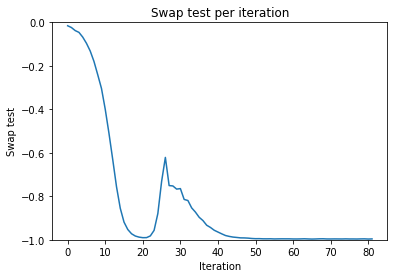

In [87]:
similarity, best_params = train_gan(build_gan_stack_with_count, data, labels, 140)

In [88]:
print(similarity)

0.9966600000000001


In [89]:
generator = build_variational_circuit(circuit_depth, circuit_width, params = best_params)

In [90]:
# print()
generator_dec = generator.decompose()
print("non_dec", generator.depth(), "dec", generator_dec.depth())
print(generator.num_qubits)

times = []
for i in range(100):
    start = time.time()

    backend = Aer.get_backend('qasm_simulator')
    job = execute(backend=backend, experiments=generator, shots=10000)
    result = job.result()
    # print(result.counts())

    end = time.time()

    times.append(end - start)
    print(end - start)

print("avg", np.mean(times))

non_dec 16 dec 64
5
0.04914999008178711
0.047046661376953125
0.04990839958190918
0.04745841026306152
0.046463727951049805
0.0448610782623291
0.04482769966125488
0.04386496543884277
0.04116559028625488
0.042737483978271484
0.045986175537109375
0.047130584716796875
0.04629969596862793
0.045630455017089844
0.05108976364135742
0.04707145690917969
0.04336237907409668
0.04708504676818848
0.03932833671569824
0.04366421699523926
0.04641079902648926
0.044972896575927734
0.04606986045837402
0.04001593589782715
0.05144953727722168
0.04562687873840332
0.042203426361083984
0.04253125190734863
0.040254831314086914
0.04449152946472168
0.04529309272766113
0.04470396041870117
0.04138660430908203
0.042679786682128906
0.04168868064880371
0.0452885627746582
0.040506601333618164
0.04053068161010742
0.04254007339477539
0.03960227966308594
0.04647541046142578
0.04624342918395996
0.0409698486328125
0.04480433464050293
0.04152178764343262
0.03875994682312012
0.04549980163574219
0.04732060432434082
0.0426015853

In [91]:
accuracy_generator, results_generator = eval_classifier(data, labels, test, generator, log=True)

features:(6.8, 3.0), label:1.0, result:0:0.9861724601497983, 1:0.9945765540258658, correct, accuracy:1.0
features:(5.0, 3.5), label:0.0, result:0:0.9973549971660685, 1:0.9847068819031435, correct, accuracy:1.0
features:(7.6, 3.0), label:1.0, result:0:0.9755006805366517, 1:0.983532317826266, correct, accuracy:1.0
features:(5.1, 3.8), label:0.0, result:0:0.9891385767790262, 1:0.9794035614674963, correct, accuracy:1.0
features:(4.4, 3.0), label:0.0, result:0:0.9957610789980733, 1:0.9962585741010186, incorrect, accuracy:0.8
features:(4.6, 3.6), label:0.0, result:0:0.986764983928909, 1:0.9745331069609509, correct, accuracy:0.8333333333333334
features:(7.7, 2.6), label:1.0, result:0:0.9567901234567902, 1:0.965123520863608, correct, accuracy:0.8571428571428571
features:(5.1, 3.5), label:0.0, result:0:0.9957496136012365, 1:0.989222797927461, correct, accuracy:0.875
features:(5.5, 3.5), label:0.0, result:0:0.9984511132623426, 1:0.9950372208436724, correct, accuracy:0.8888888888888888
features:(

# random rondklooi meuk

In [92]:
same = 0
total = 0
for i in range(len(results_generator)):
    total += 1
    print(f"generator: {results_generator[i][0]}, oracle: {results_oracle[i][0]}")
    print(results_generator[i][0] == results_oracle[i][0])
    if results_generator[i][0] == results_oracle[i][0]:
        same += 1
print("similarity:", same/total)

generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 1, oracle: 0
False
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 0, oracle: 0
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 1, oracle: 1
True
generator: 0,

In [ ]:
##### gen = build_variational_circuit(circuit_depth, circuit_width, params = params_temp)


q = QuantumRegister(gen.num_qubits)
c = ClassicalRegister(gen.num_qubits)
qc = QuantumCircuit(q, c)
qc = qc.compose(gen.to_gate(label="generator"), q)
qc.measure(q,c)

print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10001)
result = job.result()

counts = result.get_counts()
print(counts)

In [ ]:
oracle = construct_oracle(data, labels)[0]


q = QuantumRegister(oracle.num_qubits)
c = ClassicalRegister(oracle.num_qubits)
qc = QuantumCircuit(q, c)
qc = qc.compose(oracle.to_gate(label="oracle"), q)
qc.measure(q,c)

print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10001)
result = job.result()

counts = result.get_counts()
print(counts)

In [ ]:
params_temp = [0.73926341, 0.4859425 , 3.15413808, 1.09846455, 1.70353151,
       2.68071482, 2.80887   , 1.6425901 , 1.73718207, 2.66143249,
       2.5292339 , 1.27203534, 2.92013553, 1.39831892, 1.66727124,
       2.01633055, 1.52301551, 2.66952307, 1.79887383, 1.63165804,
       2.82912887, 1.60483317, 1.75210992, 1.54747312, 2.59690981,
       2.11198036, 1.30576869]

oracle = construct_oracle(data, labels)[0]
qc =build_gan_stack_with_count(circuit_depth, circuit_width, oracle, params_temp)
print(qc)
backend = Aer.get_backend('qasm_simulator')
job = execute(backend=backend, experiments=qc, shots=10001)
result = job.result()

counts = result.get_counts()
print(counts)